Here, I have demonstrated various ways of a trained decision tree. I have trained the model with sklearn. Then I have converted the decision tree model to if-else code and also covert the tree into a decision table. Also demonstrated how to use that if-else code and decision table to make predictions.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pickle

In [39]:
data = pd.read_csv('Human_Stress_Detection.csv')

In [40]:
data.head()

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
0,93.80,25.68,91.84,16.60,89.84,99.60,1.84,74.20,3
1,91.64,25104.00,91552.00,15.88,89552.00,98.88,1552.00,72.76,3
2,60.00,20.00,96.00,10.00,95.00,85.00,7.00,60.00,1
3,85.76,23536.00,90768.00,13.92,88768.00,96.92,768.00,68.84,3
4,48.12,17248.00,97872.00,6496.00,96248.00,72.48,8248.00,53.12,0


In [41]:
data.rename(columns = {'sr':'snoring_rate', 'rr':'respiration_rate',
                        't':'body_temperature', 'lm':'limb_movement', 
                        'bo':'blood_oxygen', 'rem':'eye_movement', 
                        'sr.1':'sleeping_hours','hr':'heart_rate', 
                        'sl':'stress_level'}, inplace = True)
data.head()

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
0,93.80,25.68,91.84,16.60,89.84,99.60,1.84,74.20,3
1,91.64,25104.00,91552.00,15.88,89552.00,98.88,1552.00,72.76,3
2,60.00,20.00,96.00,10.00,95.00,85.00,7.00,60.00,1
3,85.76,23536.00,90768.00,13.92,88768.00,96.92,768.00,68.84,3
4,48.12,17248.00,97872.00,6496.00,96248.00,72.48,8248.00,53.12,0


In [42]:
feature_cols = data.columns[0:8]
feature_cols

Index(['snoring_rate', 'respiration_rate', 'body_temperature', 'limb_movement',
       'blood_oxygen', 'eye_movement', 'sleeping_hours', 'heart_rate'],
      dtype='object')

**Prepare the data for training**

In [43]:
X = data.drop(['stress_level'], axis='columns')
y = data['stress_level']

In [44]:
#use uint32 data type because of hw design
X = X.astype(np.uint32)
y = y.astype(np.uint32)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

**Model creation and training**

In [47]:
model_simple = tree.DecisionTreeClassifier()
model_simple.fit(x_train, y_train)

DecisionTreeClassifier()

In [48]:
model_score = model_simple.score(x_test, y_test)
print('model score:', model_score)

model score: 0.9788359788359788


**Model score and prediction on test data**

In [49]:
predictions_test= model_simple.predict(x_test)
print('samples', len(x_test))
print('match', np.count_nonzero(predictions_test==y_test))
print('mismatch', (len(x_test) - (np.count_nonzero(predictions_test==y_test))))
print('error', ((len(x_test) - (np.count_nonzero(predictions_test==y_test))))/(len(x_test)))
print('model score', model_simple.score(x_test, y_test)*100)

samples 189
match 185
mismatch 4
error 0.021164021164021163
model score 97.88359788359789


In [50]:
classes = ['low/normal', 'medium low' , 'medium', 'medium high', 'high']

In [51]:
x_test = x_test.to_numpy(dtype=np.uint32)
y_test = y_test.to_numpy(dtype=np.uint32)

In [52]:
x_test[12]

array([   91, 25008, 91504,    15, 89504,    98,  1504,    72],
      dtype=uint32)

In [53]:
y_test[12]

3

In [54]:
sample = 12
predictions = model_simple.predict(x_test[sample].reshape(1, -1))
#return position of max  
index = predictions[0].astype(int)
prediction_label=classes[index]
print('Predected stress level during sleep: ',prediction_label) 
print('Actual stress level during sleep: ', classes[y_test[sample].astype(int)])

Predected stress level during sleep:  medium high
Actual stress level during sleep:  medium high


/net/users/Linux_Home/roy/tf/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


**Vizualization of tree**

In [55]:
print('Max Depth:', model_simple.tree_.max_depth)

Max Depth: 3


In [56]:
from sklearn.tree import _tree
ifs_count = len([x for x in model_simple.tree_.feature if x != _tree.TREE_UNDEFINED])
print('Number of decision nodes', ifs_count)

Number of decision nodes 4


In [57]:
feature_cols = data.columns[0:8]
feature_cols

Index(['snoring_rate', 'respiration_rate', 'body_temperature', 'limb_movement',
       'blood_oxygen', 'eye_movement', 'sleeping_hours', 'heart_rate'],
      dtype='object')

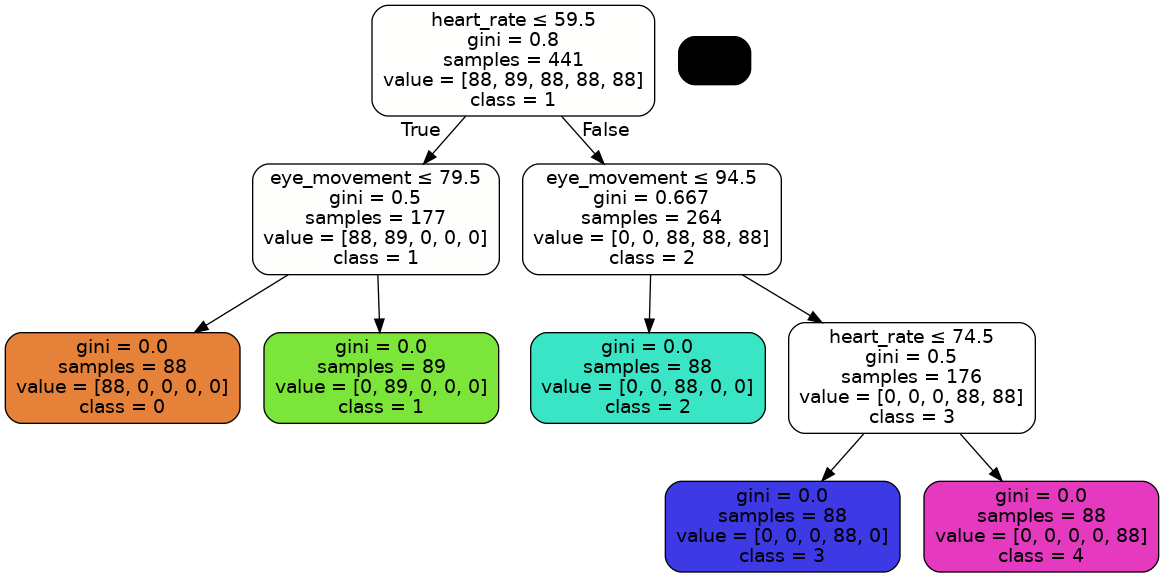

In [58]:

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(model_simple, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1', '2', '3', '4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree_img.png')
Image(graph.create_png())

**Convert decision tree to if-else code**

In [61]:
import numpy as np
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] 
                    if i != _tree.TREE_UNDEFINED else "undefined!" 
                    for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)

In [62]:
tree_to_code(model_simple, feature_cols)

def tree(snoring_rate, respiration_rate, body_temperature, limb_movement, blood_oxygen, eye_movement, sleeping_hours, heart_rate):
    if heart_rate <= 59.5:
        if eye_movement <= 79.5:
            return 0
        else:  # if eye_movement > 79.5
            return 1
    else:  # if heart_rate > 59.5
        if eye_movement <= 94.5:
            return 2
        else:  # if eye_movement > 94.5
            if heart_rate <= 74.5:
                return 3
            else:  # if heart_rate > 74.5
                return 4


**Check converted if-else with test data**

In [63]:
def tree(snoring_rate, respiration_rate, body_temperature, limb_movement, blood_oxygen, eye_movement, sleeping_hours, heart_rate):
    if eye_movement <= 84.5:
        if eye_movement <= 79.5:
            return 0
        else:  # if eye_movement > 79.5
            return 1
    else:  # if eye_movement > 84.5
        if snoring_rate <= 79.5:
            return 2
        else:  # if snoring_rate > 79.5
            if heart_rate <= 74.5:
                return 3
            else:  # if heart_rate > 74.5
                return 4


In [64]:
Prediction = tree(67, 20768, 92768, 10768, 90768, 88, 3152, 61)
print('Prediction:', Prediction)

Prediction: 2


**Decision tree model to decision table**

In [65]:
n_nodes = model_simple.tree_.node_count
children_left = model_simple.tree_.children_left
children_right = model_simple.tree_.children_right
feature = model_simple.tree_.feature
threshold = model_simple.tree_.threshold
label = model_simple.tree_.value


node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

   
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
empty_array = np.empty((0, 7))
print("The binary tree structure has %s nodes and has "
      "the following tree structure printed into decision table:"
      % n_nodes)
print("[Node number], [Input feature index], [Value to compare], [Next node if ture], [Next node if false], [is leaf], [Output]")
for i in range(n_nodes):
    if is_leaves[i]:
        n = np.array(label[i])
        outputs_index = np.argmax(n)
        empty_array = np.append(empty_array, np.array([[i, -1, -1, -1, -1, 1, outputs_index]]), axis=0)
    else:
        empty_array = np.append(empty_array, np.array([[i, feature[i], threshold[i], children_left[i], children_right[i], 0, -1]]), axis=0)
print("\n")
print(empty_array)

The binary tree structure has 9 nodes and has the following tree structure printed into decision table:
[Node number], [Input feature index], [Value to compare], [Next node if ture], [Next node if false], [is leaf], [Output]


[[ 0.   7.  59.5  1.   4.   0.  -1. ]
 [ 1.   5.  79.5  2.   3.   0.  -1. ]
 [ 2.  -1.  -1.  -1.  -1.   1.   0. ]
 [ 3.  -1.  -1.  -1.  -1.   1.   1. ]
 [ 4.   5.  94.5  5.   6.   0.  -1. ]
 [ 5.  -1.  -1.  -1.  -1.   1.   2. ]
 [ 6.   7.  74.5  7.   8.   0.  -1. ]
 [ 7.  -1.  -1.  -1.  -1.   1.   3. ]
 [ 8.  -1.  -1.  -1.  -1.   1.   4. ]]


In [66]:
file = open("decision_table.txt", "w+")
content = str(empty_array)
file.write(content)
file.close()

**Decision table to pandas dataframe for better understanding**

How to use this table? 
- Node number: The root node is 0 and then as we go down the associate node number increase
- Input feature index: We have 8 inputs as features. This index number is telling which feature is being used by the corresponding node
- Value to compare: This value is compared with the feature value
- Next node if true: Tells which node is next if the above comparison is true
- Next node if false: Tells which node is next if the above comparison is false
- is leaf: Tells you the current node is a leaf node or not
- Output: Tells you the output of the node. You will notice that some output is -1. That's because only leaf nodes have the outcomes of a given input. Other nodes do not have any outcomes.
- If any cell has -1 that means that cell does not have any use to make predictions. For example Node number 3 is a leaf node. So here we are not comparing any feature value with "Value to compare". So Input feature index is -1 here but the output has a value of 1 which is our desired outcome of the tree.

In [67]:

df = pd.DataFrame(empty_array, 
             columns=['Node number', 
                      'Input feature index',
                      'Value to compare',
                      'Next node if ture',
                      'Next node if false',
                      'is leaf',
                      'Output'])

df

,Node number,Input feature index,Value to compare,Next node if ture,Next node if false,is leaf,Output
0,0.0,7.0,59.5,1.0,4.0,0.0,-1.0
1,1.0,5.0,79.5,2.0,3.0,0.0,-1.0
2,2.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0
3,3.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
4,4.0,5.0,94.5,5.0,6.0,0.0,-1.0
5,5.0,-1.0,-1.0,-1.0,-1.0,1.0,2.0
6,6.0,7.0,74.5,7.0,8.0,0.0,-1.0
7,7.0,-1.0,-1.0,-1.0,-1.0,1.0,3.0
8,8.0,-1.0,-1.0,-1.0,-1.0,1.0,4.0


**Using the below functions we can make predictions using the data from the above table**

In [71]:
def leaf(node):
    i = node
    leaf = df.loc[df['Node number'] == i]['is leaf'].values[0]
    if leaf == 0:
        node_op(i, variable)
    else:
        global predicted_class
        predicted_class = generate_output(i)
       
    return predicted_class

def node_op(node, variable):
    i = node
    variable_index = df.loc[df['Node number'] == i]['Input feature index'].values[0]
    compare_value = df.loc[df['Node number'] == i]['Value to compare'].values[0]
    if variable_index == np.nan:
        leaf(i)
    else:
        variable_index = int(variable_index)
        variable = variable[variable_index]
    

    if compare_value == np.nan:
        leaf(i)
    else:
        if variable < compare_value:
            node = df.loc[df['Node number'] == i]['Next node if ture'].values[0]
        else: 
            node = df.loc[df['Node number'] == i]['Next node if false'].values[0]

    final_output_from_tree = leaf(node)

    return final_output_from_tree

def generate_output(node):
    i = node
    predicted_class = df.loc[df['Node number'] == i]['Output'].values[0]
    return predicted_class

In [74]:
node = 0
variable = [91, 25008, 91504,    15, 89504,    98,  1504,    72]  #input for test
x = node_op(node, variable)
print("Prediction for the inputs", x)

Prediction for the inputs 3.0
